In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN, MeanShift
from sklearn.metrics.pairwise import haversine_distances

In [2]:
def get_centeroid(cluster):
#     clustering = MeanShift(bandwidth=0.03, n_jobs=-1, max_iter=100).fit(cluster)
#     return clustering.cluster_centers_[0].tolist()
	lon, lat = 0, 0
	for row in cluster.itertuples(index=False):
		lat += row.lat
		lon += row.lon
	return [lat / len(cluster), lon / len(cluster)] # [longitude, latitude]

In [3]:
def _dbscan(df, eps_rad, msp, filter_speed=True):
	# filter the speed
	if filter_speed:
		df = df[df['speed'] <= 1]
	df = df.sample(frac=1 if len(df) <= 48000 else 48000/len(df))
	if len(df) == 0:
		return None

	
	coords = df[['lat', 'lon']]
	db = DBSCAN(eps=eps_rad, min_samples=msp, algorithm='ball_tree', metric='haversine', n_jobs=12).fit(np.radians(coords))
	cluster_lables = db.labels_
	n_clusters = len(set(cluster_lables)) - (1 if -1 in cluster_lables else 0)
	n_noise_ = list(cluster_lables).count(-1)
	if n_clusters == 0:
		return None

	clusters = pd.Series([coords[cluster_lables == n] for n in range(n_clusters)])
	centers = clusters.map(get_centeroid).tolist()
	return centers

In [4]:
def closest_node(node, nodes):
	closest_index, dist = -1, 1e12
	for i in range(len(nodes)):
		curdis = haversine_distances(np.radians([node]), np.radians([nodes[i]]))[0][0] * 6371
		if curdis < dist:
			dist, closest_index = curdis, i

	# if dist < 50:
	# 	print("{}\t{},{}\t{},{}".format(dist, node[0], node[1], nodes[closest_index][0], nodes[closest_index][1]))
	return closest_index if dist < 5 else -1

In [5]:
data = pd.read_csv('solved.csv', delim_whitespace=True)
data['geohash'] = pd.to_numeric(data['geohash'])
print(data.info())

dflist = [[] for _ in range(256)]
for row in data.itertuples(index=False):
    dflist[row.geohash >> 56].append(row)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7896919 entries, 0 to 7896918
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   mmsi       int64  
 1   timestamp  int64  
 2   speed      int64  
 3   status     int64  
 4   lon        float64
 5   lat        float64
 6   draught    float64
 7   geohash    uint64 
dtypes: float64(3), int64(4), uint64(1)
memory usage: 482.0 MB
None


In [6]:
colNames = ['mmsi', 'timestamp', 'status', 'speed', 'lon', 'lat', 'draught', 'geohash']
kms_per_radian = 6371.
# eps_rad = 5 / kms_per_radian
eps_rad = 1 / kms_per_radian
centers = []
for i in range(256):
    df = pd.DataFrame.from_records(dflist[i], columns=colNames)
    # res = _dbscan(df, eps_rad, 500)
    res = _dbscan(df, eps_rad, 375)
    print("---Block {} finished---".format(i))
    if res is None:
        continue
    centers.extend(res)

---Block 0 finished---
---Block 1 finished---
---Block 2 finished---
---Block 3 finished---
---Block 4 finished---
---Block 5 finished---
---Block 6 finished---
---Block 7 finished---
---Block 8 finished---
---Block 9 finished---
---Block 10 finished---
---Block 11 finished---
---Block 12 finished---
---Block 13 finished---
---Block 14 finished---
---Block 15 finished---
---Block 16 finished---
---Block 17 finished---
---Block 18 finished---
---Block 19 finished---
---Block 20 finished---
---Block 21 finished---
---Block 22 finished---
---Block 23 finished---
---Block 24 finished---
---Block 25 finished---
---Block 26 finished---
---Block 27 finished---
---Block 28 finished---
---Block 29 finished---
---Block 30 finished---
---Block 31 finished---
---Block 32 finished---
---Block 33 finished---
---Block 34 finished---
---Block 35 finished---
---Block 36 finished---
---Block 37 finished---
---Block 38 finished---
---Block 39 finished---
---Block 40 finished---
---Block 41 finished---
--

In [7]:
centers = pd.DataFrame(centers, columns=['lat', 'lon'])
result = _dbscan(centers, 3/kms_per_radian, 1, False)

prev, flg = None, 0
incls, total = 0, 0
stat = [0 for _ in range(len(result))]
for row in data.itertuples(index=False):
    if flg == 0:
        flg += 1
    elif abs(row.draught - prev.draught) > 2 and row.mmsi == prev.mmsi:
        # cls = closest_node([data.iloc[i].lat, data.iloc[i].lon], [[-89, 179], [0, 0], [12, 34], [56, 78]])
        cls = closest_node([row.lat, row.lon], result)
        total += 1
        incls += 1 if cls != -1 else 0
        # stat[cls] += 1
        stat[cls] += 1 if row.draught > prev.draught else -1

    prev = row

In [8]:
print(len(result))
print(incls / total * 100)
print(stat)
lngs = [result[i] for i, e in enumerate(stat) if abs(e) > 2]
check = [[result[i], stat[i]] for i, e in enumerate(stat) if abs(e) > 2]
print(result)
print(len(lngs))
print(lngs)

376
82.74381868131869
[9, 1, 1, -9, 0, 0, 0, 12, -20, 0, -13, 0, -13, 8, 0, -62, -22, -5, -4, -9, -1, 1, -22, -1, -1, 0, 0, -2, 0, -1, -64, 0, -1, -3, -31, -2, -1, -1, -35, -3, -53, -6, 2, -1, 2, 0, -4, 0, -3, 3, -4, -3, 1, 0, 1, -11, 66, -2, -49, 83, -12, 0, 0, -15, -2, -18, -34, 0, -1, -2, -13, 2, -3, 5, 0, 0, -1, -1, -1, 1, 0, 0, -3, -1, 55, 1, -2, -1, 0, 0, -17, 2, -1, -1, -2, 1, -2, -3, -23, -6, -19, -1, -2, -36, 25, -1, 0, -18, 2, -11, 3, 9, 0, -10, 0, -2, 2, -6, -2, 0, -1, 397, 3, -1, 0, -1, 0, -1, 0, 1, 9, -1, -2, 0, -13, -13, 18, -1, -1, 0, 1, -11, 0, 0, 0, -9, -1, -39, -10, -5, -27, 0, -8, -12, -1, 0, -1, -11, -8, -17, -8, 117, -5, 0, 0, -1, 2, 0, 2, 0, -10, 6, 0, -1, -5, 0, -6, -14, -2, 0, 159, -36, 0, -25, -18, -6, -5, -3, -12, -8, -9, -2, 8, -3, -5, 0, -5, -1, -33, -5, 1, 0, -15, 17, 0, 1, 68, -48, -2, -1, -2, -2, 0, -11, 24, -1, 0, 6, 0, -1, -3, -1, -26, -22, 0, 10, -2, -30, 5, -16, 7, -12, -22, -66, -4, -12, -1, 0, -1, -6, -4, -16, -2, -1, 8, -6, 6, -13, -3, 5, 0, -1, 0,

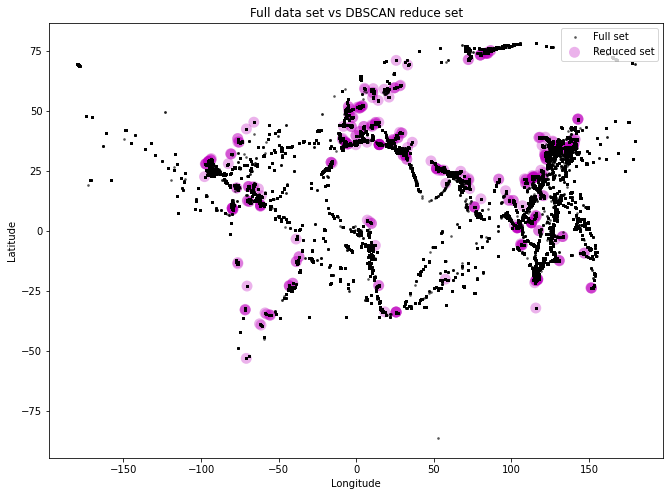

In [9]:
result = pd.DataFrame(result, columns=['lat', 'lon'])
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(result['lon'], result['lat'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(data['lon'], data['lat'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduce set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

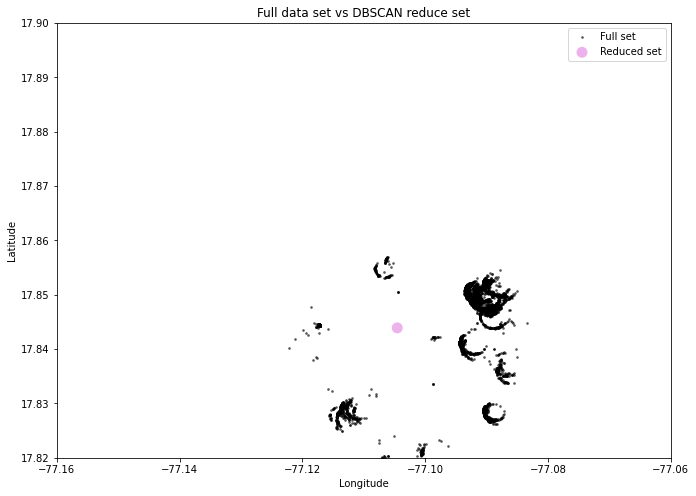

In [10]:
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(result['lon'], result['lat'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(data['lon'], data['lat'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduce set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim([-77.16, -77.06])
ax.set_ylim([17.82, 17.90])
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [11]:
print(check)

[[[-2.4251384979536166, 133.1334803328789], 9], [[18.407997835393004, -69.625996283737], -9], [[31.4665219829589, 31.752107172734263], 12], [[-12.81436835955674, -38.68035146633985], -20], [[25.031659731601724, 55.067577283549774], -13], [[43.36429319127269, -3.095121441454546], -13], [[52.01900141956086, 3.5088188936353752], 8], [[37.33755120313445, 126.58741948041892], -62], [[41.342733491311414, 2.1625401818306034], -22], [[-21.835362766246202, -40.993589518913794], -5], [[28.844234640278582, -95.14570419235719], -4], [[35.517143335705654, 129.43777254796498], -9], [[21.54692507563442, 91.81743869719844], -22], [[35.46551097121326, 139.7286007287882], -64], [[9.34003368986085, -79.91135159045739], -3], [[34.76381712872286, 134.6900227612281], -31], [[34.559176915092706, 135.4072531908909], -35], [[19.98138420279712, 110.05516429603718], -3], [[24.25133960634375, 120.49832629883615], -53], [[10.302526691932757, -61.722351656285554], -6], [[-20.166520191030898, 116.99946125684309], -4